# 3 point - DG

Here we compare the two types of loss targets and the MSE vs MAE loss functions. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-17 15:17:24.901118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 15:17:24.919481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 15:17:24.925172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [18]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],


                    'all_time_range': slice(200, -1),
                    'train_time_range': slice(0, 2048),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/'
                    
            }
common_config['num_inputs'] = 6* common_config['window_size']**2

In [6]:
experiment_config = {'dim_MSE': {'loss_type':'mse', 
                                 'output_channels': ['uphp_rotated','vphp_rotated'],
                                 'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 
                                 'use_coeff_channels': True, 
                                 'extra_channels': [] }, 
                     'nondim_MSE': {'loss_type':'mse', 
                                    'output_channels': ['uphp_rotated_nondim','vphp_rotated_nondim'],
                                    'coeff_channels'  : [], 
                                    'use_coeff_channels': False,
                                    'extra_channels' : ['uphp_rotated',
                                                        'vphp_rotated', 
                                                        'mag_nabla_h_widened',
                                                        'mag_nabla_u_widened',
                                                        'filter_scale'],},
                     'dim_MAE': {'loss_type':'mae', 
                                 'output_channels': ['uphp_rotated','vphp_rotated'],
                                 'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'],
                                 'use_coeff_channels': True,
                                 'extra_channels': [] }, 
                     'nondim_MAE': {'loss_type':'mae', 
                                    'output_channels': ['uphp_rotated_nondim','vphp_rotated_nondim'],
                                    'coeff_channels'  : [], 
                                    'use_coeff_channels': False,
                                    'extra_channels' : ['uphp_rotated',
                                                        'vphp_rotated', 
                                                        'mag_nabla_h_widened',
                                                        'mag_nabla_u_widened',
                                                        'filter_scale'],} 
                    }

In [7]:
for key in experiment_config.keys(): 
    experiment_config[key]['exp_ckpt_save_dir'] = common_config['exp_ckpt_save_dir'] + key

In [8]:
experiment_config

{'dim_MSE': {'loss_type': 'mse',
  'output_channels': ['uphp_rotated', 'vphp_rotated'],
  'coeff_channels': ['filter_scale',
   'filter_scale',
   'mag_nabla_h_widened',
   'mag_nabla_u_widened'],
  'use_coeff_channels': True,
  'extra_channels': [],
  'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/dim_MSE'},
 'nondim_MSE': {'loss_type': 'mse',
  'output_channels': ['uphp_rotated_nondim', 'vphp_rotated_nondim'],
  'coeff_channels': [],
  'use_coeff_channels': False,
  'extra_channels': ['uphp_rotated',
   'vphp_rotated',
   'mag_nabla_h_widened',
   'mag_nabla_u_widened',
   'filter_scale'],
  'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/nondim_MSE'},
 'dim_MAE': {'loss_type': 'mae',
  'output_channels': ['uphp_rotated', 'vphp_rotated'],
  'coeff_channels': ['filter_scale',
   'filter_scale',
   'mag_nabla_h_widened',
   'mag_nabla_u_widened'],
  'use_coeff_channels': True,
  'extra_chan

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [9]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=True,
                             #e_ugrad = 1e-9,
                             #e_hgrad = 1e-5
                             )

In [10]:
DT.simulation_data

DataTree('None', parent=None)
└── DataTree('DG')
    ├── DataTree('50')
    │       Dimensions:                      (Time: 3399, xh: 200, yh: 218, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 27kB 0006-07-04 00:00:00 ... 0...
    │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
    │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
    │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/67)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 21GB dask.array<chunksize=(16, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 21GB dask.array<chunksize=(16, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 21GB dask.array<chunksize=(16, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 21GB dask.array<chunksize=(16, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 21GB dask.array<chunksize=(16, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 21GB dask.array<chunksize=(16, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           ...                           ...
    │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 2GB dask.array<chunksize=(16, 2, 217, 199), meta=np.ndarray>
    │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 2GB dask.array<chunksize=(16, 2, 217, 199), meta=np.ndarray>
    │           uphp_nondim                  (Time, zl, yh, xh) float64 2GB dask.array<chunksize=(16, 2, 217, 199), meta=np.ndarray>
    │           vphp_nondim                  (Time, zl, yh, xh) float64 2GB dask.array<chunksize=(16, 2, 217, 199), meta=np.ndarray>
    │           Rd_nondim                    (Time, yh, xh) float64 1GB dask.array<chunksize=(16, 218, 200), meta=np.ndarray>
    │           single_layer_mask            (Time, yh, xh) float64 1GB dask.array<chunksize=(16, 218, 200), meta=np.ndarray>
    │       Attributes:
    │           simulation_name:  DG
    │           filter_scale:     50
    │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
    │           description:      Dataset for DG experiment at 50 km resolution
    ├── DataTree('100')
    │       Dimensions:                      (Time: 3399, xh: 100, yh: 108, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 27kB 0006-07-04 00:00:00 ... 0...
    │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
    │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
    │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/67)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
    │           dvdy_widened                 (Time, zl,

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [11]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data  = DT, 
                                       all_ml_variables = common_config['all_ml_variables'],
                                       time_range       = common_config['train_time_range'],
                                       num_batches      = common_config['num_train_batches'])

Will load : 5.7851904 gb into memory.
load took: 124.2117 seconds


In [12]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data  = DT,
                                      all_ml_variables = common_config['all_ml_variables'],
                                      time_range       = common_config['test_time_range'],
                                      num_batches      = common_config['num_test_batches'])

Will load : 0.3615744 gb into memory.
load took: 9.4920 seconds


In [13]:
len(ML_DT_train.ml_batches), len(ML_DT_test.ml_batches) 

(128, 8)

In [14]:
ML_DT_train.ml_batches[0]

<xarray.Dataset> Size: 26MB
Dimensions:                      (Xn: 3, Yn: 3, points: 49753)
Coordinates:
  * points                       (points) object 398kB MultiIndex
  * Time                         (points) object 398kB 0057-07-16 00:00:00 .....
  * xh                           (points) float64 398kB 7.095 16.94 ... 4.84
  * yh                           (points) float64 398kB 40.32 45.09 ... 36.91
  * zl                           (points) float64 398kB 1.035e+03 ... 1.035e+03
Dimensions without coordinates: Xn, Yn
Data variables: (12/13)
    dudx_widened_rotated_nondim  (Xn, Yn, points) float64 4MB 0.05786 ... -0....
    dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.3119 ... -0....
    dudy_widened_rotated_nondim  (Xn, Yn, points) float64 4MB 0.1257 ... -0.2337
    dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.06048 ... 0.148
    dhdx_widened_rotated_nondim  (Xn, Yn, points) float64 4MB 0.1254 ... 0.1348
    dhdy_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.09889 ... 0....
    ...                           ...
    filter_scale                 (points) float64 398kB 4.803e+04 ... 3.934e+05
    mag_nabla_u_widened          (points) float64 398kB 2.557e-05 ... 7.922e-07
    uphp_rotated                 (points) float64 398kB 0.03628 ... -0.8397
    vphp_rotated                 (points) float64 398kB -0.3698 ... -0.636
    uphp_rotated_nondim          (points) float64 398kB 0.0004924 ... -0.01241
    vphp_rotated_nondim          (points) float64 398kB -0.005019 ... -0.009397
Attributes:
    simulation_name:  DG
    filter_scale:     50
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
    description:      Dataset for DG experiment at 50 km resolution

## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [15]:
for key in experiment_config.keys(): 
    print(key)
    train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=common_config['input_channels'], 
                                      output_channels=experiment_config[key]['output_channels'], 
                                      coeff_channels=experiment_config[key]['coeff_channels'], 
                                      use_coeff_channels=experiment_config[key]['use_coeff_channels'],
                                      do_normalize=True)
    test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=common_config['input_channels'], 
                                      output_channels=experiment_config[key]['output_channels'], 
                                      coeff_channels=experiment_config[key]['coeff_channels'],
                                      use_coeff_channels=experiment_config[key]['use_coeff_channels'],
                                      do_normalize=True)
    experiment_config[key]['ML_data_combo'] = {'train_data':train_ML_data, 'test_data':test_ML_data}    

dim_MSE
nondim_MSE
dim_MAE
nondim_MAE


In [16]:
for batch_out in  experiment_config[key]['ML_data_combo']['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Input (Xp) batch shape:", batch_out['Xp'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (49753, 54)
Input (Xp) batch shape: (49753, 2)
Output (y) batch shape: (49753, 2)


## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [20]:
for key in experiment_config.keys(): 
    print(key)

    ML_data_combo = experiment_config[key]['ML_data_combo'] 
    
    ANN_model = ML_classes.PointwiseANN(num_in = common_config['num_inputs'],
                                    shape = common_config['network_shape']) 

    regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type=experiment_config[key]['loss_type'])

    print('Start training: ', key)
    regress_sys.train_system(ML_data_combo, num_epoch=501, print_freq=20, min_relative_improvement=1e-2)

    experiment_config[key]['regress_sys'] = regress_sys
    regress_sys.save_checkpoint(experiment_config[key]['exp_ckpt_save_dir'])

dim_MSE
Start training:  dim_MSE
At epoch 1. Train loss :  11.085030727088451 , Test loss: 8.108597695827484 , Test R2: 0.4930408373475075
At epoch 21. Train loss :  4.557434089481831 , Test loss: 4.694653570652008 , Test R2: 0.7062541171908379
At epoch 41. Train loss :  4.257524870336056 , Test loss: 4.386968672275543 , Test R2: 0.7255340665578842
At epoch 61. Train loss :  4.11308672092855 , Test loss: 4.23804897069931 , Test R2: 0.7348301187157631
Early stopping at epoch 79. No improvement in 10 epochs.
Restored best model with smoothed test loss 4.211225
nondim_MSE
Start training:  nondim_MSE
At epoch 1. Train loss :  0.2914643691619858 , Test loss: 0.2483721449971199 , Test R2: 0.022425152361392975
At epoch 21. Train loss :  0.2134007685817778 , Test loss: 0.20456906966865063 , Test R2: 0.19483710080385208
At epoch 41. Train loss :  0.2086654637241736 , Test loss: 0.19989069737493992 , Test R2: 0.21322399377822876
Early stopping at epoch 49. No improvement in 10 epochs.
Restored b

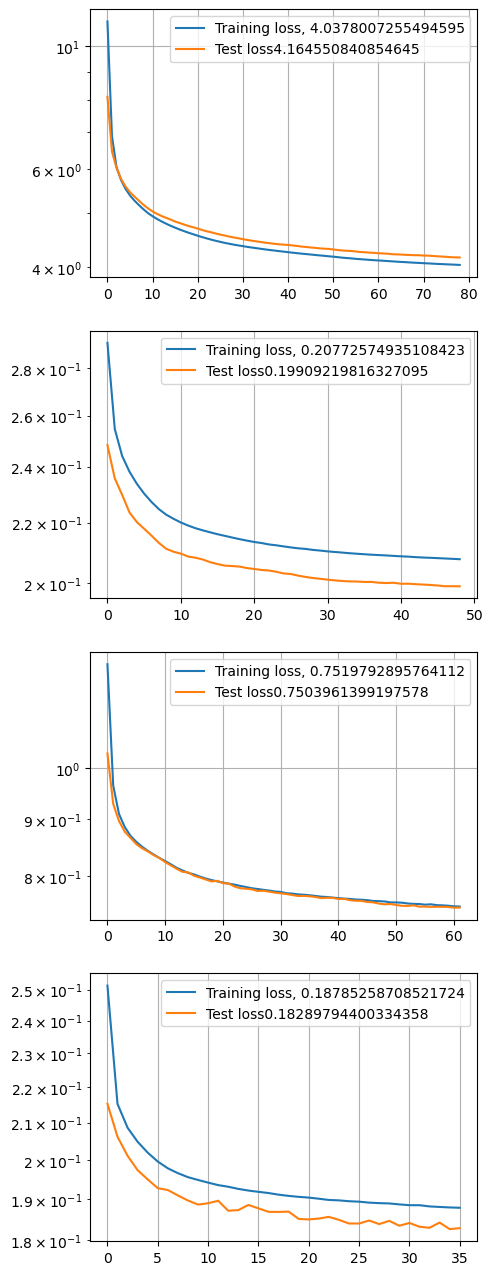

In [23]:
## Loss plot
num_models = len(experiment_config.keys())

fig = plt.figure(figsize=(5, 4*num_models)) 

for i, key in enumerate(experiment_config.keys()): 
    plt.subplot(num_models, 1, i+1)
    regress_sys = experiment_config[key]['regress_sys']
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))
    
    plt.grid()
    plt.yscale('log')
    plt.legend()

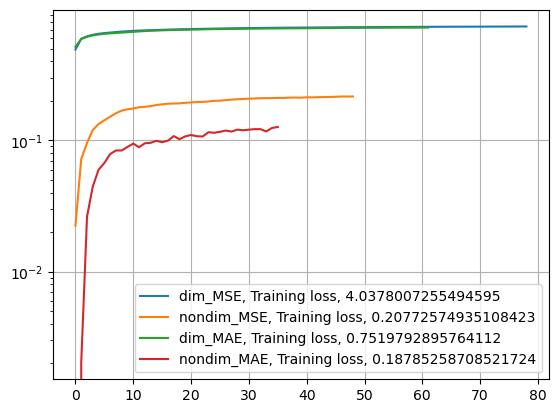

In [26]:
## Loss plot
num_models = len(experiment_config.keys())

#fig = plt.figure(figsize=(5, 4*num_models)) 

for i, key in enumerate(experiment_config.keys()): 
    #plt.subplot(num_models, 1, i+1)
    regress_sys = experiment_config[key]['regress_sys']
    plt.plot(regress_sys.test_R2, label=key+', Training loss, '+str(regress_sys.train_loss[-1]))
    
plt.grid()
plt.yscale('log')
plt.legend()